# Notebook Setup

In [1]:
import os
import logging
import sys
%matplotlib inline

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
# Add src and dependencies/Model_Checking folders to environmental path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src')))

# Simulator

## Load Model

In [4]:
from src.util import get_model

In [5]:
base_name = 'Tcell_boolean_biorecipe'
model_file = 'models/example_model_' + base_name + '.xlsx'
model = get_model(model_file)

In [6]:
# display a subset of model columns 
model[['Element Name','Positive Regulation Rule','Negative Regulation Rule','State List 0']]

,Element Name,Positive Regulation Rule,Negative Regulation Rule,State List 0
Variable,,,,
AKT,AKT,"(PDK1,MTORC2)",AKT_OFF,0
AKT_OFF,AKT_OFF,,,0
AP1,AP1,"(FOS_DD,JUN)",,0
CA,CA,TCR,,0
CD122,CD122,,,1
...,...,...,...,...
TCR,TCR,"TCR_LOW,TCR_HIGH",,0
TCR_HIGH,TCR_HIGH,,,0
TCR_LOW,TCR_LOW,,,0


## Simulate

In [7]:
from src import simulator_interface as sim
import warnings
warnings.filterwarnings('ignore')

In [8]:
print('Number of the model nodes: ',len(model))

Number of the model nodes:  61


In [9]:
# In the last columns of your model spreadsheet, you have Intial 0, Initial 1, ..., etc to specify initials
scenario_labels = [x.strip() for x in model.columns if ('state list' in x.lower())]
print('Scenario index include: ', scenario_labels)

Scenario index include:  ['State List 0', 'State List 1', 'State List 2']


In [10]:
# define simulation parameters

# the folder you'd like to store your simulation results
output_path = 'traces'

# steps indicate how long you run your model each time
# steps need to be 3 or 4 times of the number of the model nodes
steps = 500

# runs indicate how many times you run model simulation
# sync scheme updates all elements at one step and therefore it is deterministic
# if sync, you can set runs = 1
# random sequential scheme updates element one by one, and the element to be updated is randomly chosen
# if random, you can set runs = 100 to see average results
runs = 200

# set it to be 1 if you just need to run simulator and visualize the simulation results
# set it to be 2 if you need to conduct sensitivity after simulation without visualizing the simulation results
output_format = 1

# if sync, scheme = 'sync'; if random, scheme = 'ra'
scheme = 'ra'

In [11]:
# no need to change, set up output paths
scenarios_index = list(range(len(scenario_labels)))
scenarios_sorted = [str(x) for x in sorted(scenarios_index)]
if not os.path.exists(output_path):
    os.mkdir(output_path)
output_basename = os.path.join(output_path,'example_traces_transpose_' + base_name)

In [12]:
# simulate
sim.setup_and_run_simulation(
         model_file, 
         output_basename + '.txt', 
         steps, 
         runs, 
         scheme, 
         output_format,
         ','.join(scenarios_sorted)
         )
# trajectories of different scenarios are stored separately and indexed

INFO:root:Simulation scenario 0 complete
INFO:root:Simulation scenario 1 complete
INFO:root:Simulation scenario 2 complete


## Visualize simulation results

In [13]:
import visualization_interface as viz

### Define parameters and load from files

In [14]:
# define visualization parameters

# list the elements of interest you will study
# when your model is small, you can choose all elements by setting list as ['']
#elements_of_interest = ['food_price_or_cost', 'malnutrition', 'food_aid']
elements_of_interest = ['PDK1','MTORC2','IL2R','FOXP3','MTORC1','AKT','PIP3']

# list the scenarios of interest you will study
# when you have a few scenarios, you can list them all
scenarios = [0,1,2]

# no need to change
colors = None # can be a list of colors, length matching the number of scenarios
linestyles = None # can be a list, length matching the number of scenarios
linewidth = 2
normalize_levels = True # whether to plot y axis as a percentage

In [15]:
# no need to change
# construct list of trace files automatically generated by the simulator
scenarios_sorted = [str(x) for x in sorted(scenarios)]
if len(scenarios_sorted) > 1:
    trace_files = [
                output_basename + '_' + str(this_scenario) + '.txt'
                for this_scenario in scenarios_sorted
                ]
else:
    trace_files = [output_basename + '.txt']

# get trace data
traces_list = [viz.get_traces(trace_file) for trace_file in trace_files]

### Average traces

In [16]:
scenario_labels = ['0', '1', '2']
avg_plots = viz.plot_average(
        traces_list, 
        elements_list = elements_of_interest, 
        normalize_levels = normalize_levels,
        errorbars = False,
        scenario_labels = scenario_labels,
        style = 'whitegrid',
        linewidth = linewidth,
        colors = colors,
        linestyles = linestyles
        )

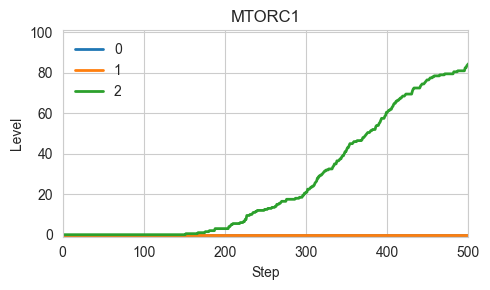

In [17]:
# show average plot for one element in your elements_of_interest list
element = 'MTORC1'
avg_plots[element]

In [18]:
# save plots to files
plots_path = 'plots'
file_format = 'png' # pdf is also supported

# make output directory
if not os.path.exists(plots_path):
    os.mkdir(plots_path)

viz.save_plots(
    avg_plots,
    plots_path,
    file_format = file_format
    )

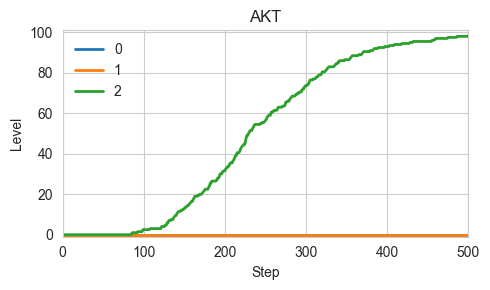

In [19]:
# you can also modify the plot objects
avg_plots['MTORC1'].axes[0].axvspan(
        150, 
        200,
        color='gray', 
        alpha=0.2
        )
avg_plots['AKT']

### Heatmaps

In [20]:
# plot only one scenario per plot for heatmaps
# change below to traces_list[1] etc for other scenarios
heatmap_plots = viz.plot_heatmap(
        traces_list[1],
        elements_list = elements_of_interest, 
        normalize_levels = normalize_levels
        )

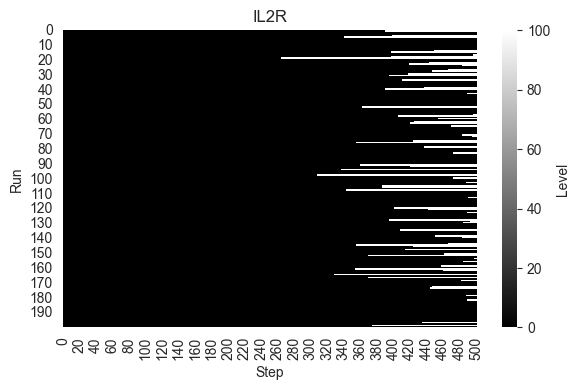

In [21]:
# choose one element in your elements_of_interest list
element = 'IL2R'
heatmap_plots[element]

### Plot each run

In [22]:
# only one scenario per plot for heatmaps
run_plots = viz.plot_each_run(
        traces_list[1],
        elements_list = elements_of_interest, 
        normalize_levels = normalize_levels
        )

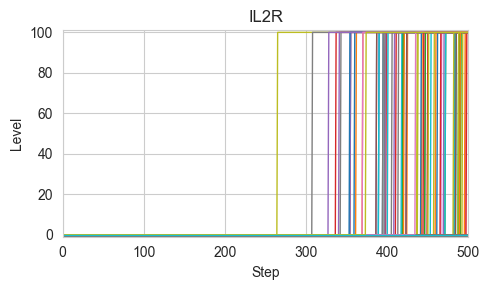

In [23]:
# choose one element in your elements_of_interest list
element = 'IL2R'
run_plots[element]

### Compare traces between scenarios

In [24]:
# compare other scenarios to first scenario
# using default scenario labels
compare_plots = viz.plot_compared_average(    
        traces_list, 
        elements_list = elements_of_interest, 
        normalize_levels = normalize_levels,
        comparison = 'difference', 
        style = 'whitegrid',
        linewidth = linewidth
        )

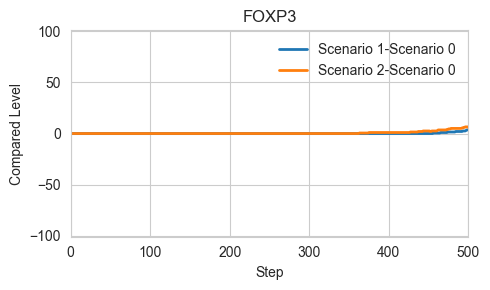

In [25]:
# choose one element in your elements_of_interest list
compare_plots['FOXP3']

### Compare multiple elements

In [26]:
# only one scenario per plot
elements_plot = viz.plot_average_multiple_elements(
    traces_list[1],
    elements_list = elements_of_interest, 
    normalize_levels = normalize_levels,
    errorbars = False,
    style = 'whitegrid',
    linewidth = linewidth,
    colors = colors,
    linestyles = linestyles
    )

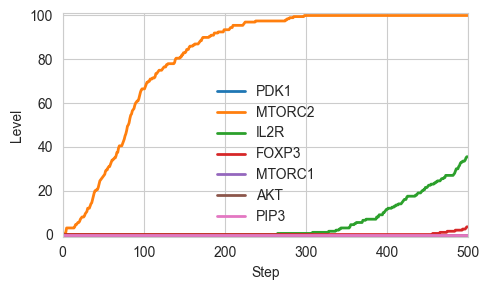

In [27]:
elements_plot

### Get end values

In [28]:
# obtain the final value of all elements in elements_of_interest list
# only one scenario, can change to other scenarios
end_values = viz.get_end_values(traces_list[1], elements_of_interest)
end_values

{'PDK1': 0.0,
 'MTORC2': 100.0,
 'IL2R': 35.5,
 'FOXP3': 3.5000000000000004,
 'MTORC1': 0.0,
 'AKT': 0.0,
 'PIP3': 0.0}